In [1]:
import os
import numpy as np
import pandas as pd
import lib.galaxy_utilities as gu
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from astropy.io import fits
from astropy.wcs import WCS
import astropy.units as u
import lib.make_cutouts as mkct
import gzbuilder_analysis.rendering as rg
import reproject

In [2]:
fitting_metadata = pd.read_pickle('lib/fitting_metadata.pkl')
subject_id = 20902029

In [3]:
gal = gu.get_galaxy_and_angle(subject_id)[0]
input_frames_path = mkct.get_montage_frames(gal)

output_mosiac_path = os.path.join(
    '/', *mkct.get_montage_frames(gal)[0].split('/')[:-1], 'mosaic.fits'
).replace('montageGroups', 'montageOutputs')

In [4]:
output_mosiac = fits.open(output_mosiac_path)
input_frames = list(map(fits.open, input_frames_path))

In [5]:
output_wcs = WCS(output_mosiac[0])
input_wcs = [WCS(f[0]) for f in input_frames]

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [6]:
ra, dec = gu.metadata.loc[subject_id][['ra', 'dec']]

In [18]:
def get_reprojected_data(frame_loc, output_mosiac_path, ra, dec):
    # open the file
    frame = fits.open(frame_loc)
    # extract the HDU
    hdu = frame[0]
    # calculate a WCS object
    wcs = WCS(hdu.header)
    # Define cutout positions
    centre_pos = mkct.SkyCoord(
        ra, dec,
        unit=u.degree, frame='fk5'
    )
    dx = 4 * float(gal['PETRO_THETA']) * u.arcsec
    dy = 4 * float(gal['PETRO_THETA']) * u.arcsec
    # Grab the cutout
    cutout_im = mkct.Cutout2D(
        hdu.data,
        centre_pos,
        (dx, dy),
        wcs=wcs,
        mode='partial',
        copy=True,
    )
    # Update the HDU with the new data and WCS
    hdu.data = cutout_im.data
    hdu.header.update(cutout_im.wcs.to_header())
    # Reproject the HDU to the montaged coordinate space
    array, _ = reproject.reproject_interp(
        hdu,
        output_mosiac[0].header
    )
    im = mkct.Cutout2D(
        array,
        centre_pos,
        (dx, dy),
        wcs=WCS(output_mosiac[0].header),
        mode='partial',
        copy=True,
    )
    # reload the frame
    frame = fits.open(frame_loc)
    sigma = mkct.get_sigma_image(frame)
    cutout_sigma = mkct.Cutout2D(
        sigma,
        centre_pos,
        (dx, dy),
        wcs=wcs,
        mode='partial',
        copy=True,
    )
    hdu.data = cutout_sigma.data
    hdu.header.update(cutout_sigma.wcs.to_header())
    # Reproject the HDU to the montaged coordinate space
    sigma_array, _ = reproject.reproject_interp(
        hdu,
        output_mosiac[0].header
    )
    sigma_cutout = mkct.Cutout2D(
        sigma_array,
        centre_pos,
        (dx, dy),
        wcs=WCS(output_mosiac[0].header),
        mode='partial',
        copy=True,
    )
    return im.data, sigma_cutout.data

In [19]:
output = pd.Series([])
for i, frame in enumerate(input_frames_path):
    try:
        im, sigma = get_reprojected_data(frame)
        output.loc[i] = {'image': im, 'sigma_image': sigma}
    except ValueError as e:
        print(e)
output = output.apply(pd.Series)

Arrays do not overlap.


/Users/tlingard/anaconda3/lib/python3.6/site-packages/reproject/interpolation/core_celestial.py:26: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(array.dtype, np.float):


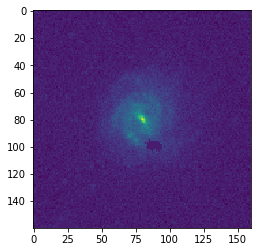

In [29]:
gu.get_image(20902029)
plt.imshow(gu.get_diff_data(20902029)['imageData'])

In [20]:
output

,image,sigma_image
1,"[[-0.027989075199984694, -0.025939157636075776...","[[0.02713448206667981, 0.027174798156347126, 0..."


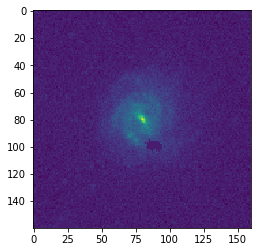

In [21]:
data = fitting_metadata.loc[subject_id].galaxy_data
mask = fitting_metadata.loc[subject_id].pixel_mask
plt.imshow(fitting_metadata.loc[subject_id].galaxy_data)

In [22]:
im_stack = np.stack(output['image'].apply(lambda a: a.data).values)
im_mean = np.nanmean(im_stack, axis=0)
pixel_counts = np.isfinite(im_stack).astype(int).sum(axis=0)
sigma_mean = np.sqrt(
    np.nansum(
        np.stack(output['sigma_image'].apply(lambda a: a.data).values)**2,
        axis=0,
    )
) / pixel_counts

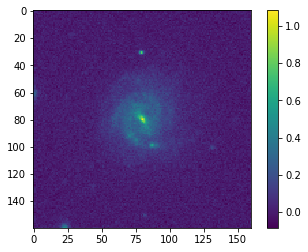

In [27]:
plt.imshow(im_mean)
plt.colorbar()

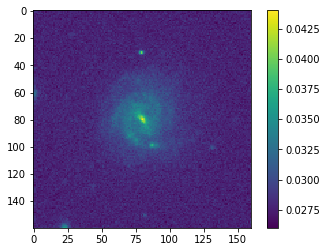

In [26]:
plt.imshow(sigma_mean)
plt.colorbar()

In [14]:
m = gu.get_diff_data(subject_id)['multiplier']

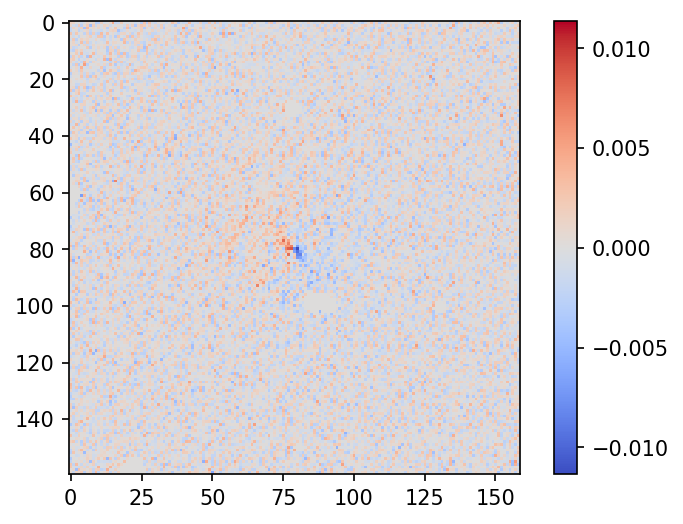

In [15]:
plt.figure(dpi=150)
d = (im_mean * mask / m - data)[:, 1:]
plt.imshow(d, vmin=-np.abs(d).max(), vmax=np.abs(d).max(), cmap='coolwarm')
plt.colorbar()

In [16]:
gal2 = gal.copy()
gal2['RA'] = gu.metadata.loc[subject_id]['ra']
gal2['DEC'] = gu.metadata.loc[subject_id]['dec']
im, sd = mkct.get_data(gal2, montage=True)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


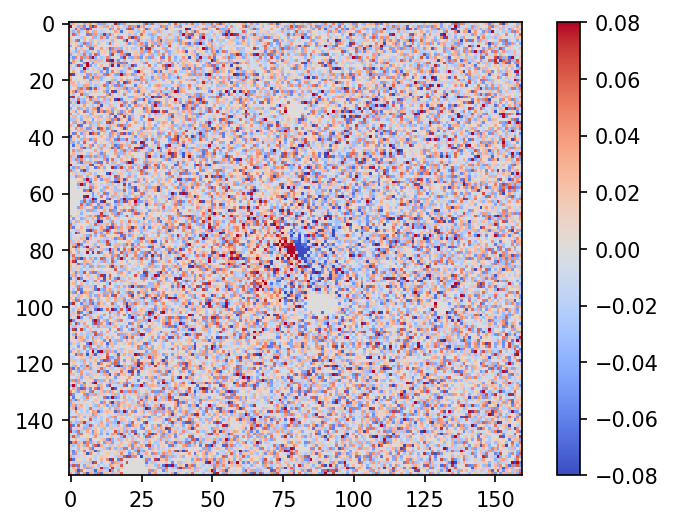

In [17]:
plt.figure(dpi=150)
plt.imshow(im[::-1].T * mask / m - data, vmin=-0.08, vmax=0.08, cmap='coolwarm')
plt.colorbar()